In [100]:
from tkinter import *

from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns

import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential
from keras.models import model_from_json
import pickle
from sklearn.model_selection import train_test_split 

In [101]:
#path of dataset
path = 'Dataset'
#names of all pattern classes
labels = ['Checkered', 'Dotted', 'Floral', 'Patternless', 'Striped', 'Zigzag']

In [102]:
#function to return integer label 
def getID(name):
    index = 0
    for i in range(len(labels)):
        if labels[i] == name: #return integer ID as label 
            index = i
            break
    return index

In [103]:
if os.path.exists("X.txt.npy"):#if images already processed then load it
    X = np.load('X.txt.npy') #load X and Y data
    Y = np.load('Y.txt.npy')
else: #if not processed image then process and save
    X = []
    Y = []
    #looping all images from all folders
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j]) #read image
                img = cv2.resize(img, (32,32)) #resize image
                im2arr = np.array(img)
                im2arr = im2arr.reshape(32,32,3) #resize as colur image
                label = getID(name) #get id or label 
                X.append(im2arr) #add all image pixel to X array
                Y.append(label) #add label to Y array
                print(name+" "+root+"/"+directory[j]+" "+str(label))        
    X = np.asarray(X)
    Y = np.asarray(Y)
    np.save('model/X.txt',X) #save X and Y data for future user
    np.save('model/Y.txt',Y)
print()    
print("Total pattern images found in dataset : "+str(X.shape[0]))
print("Total patterns found in dataset : "+str(labels))
print()


Total pattern images found in dataset : 400
Total patterns found in dataset : ['Checkered', 'Dotted', 'Floral', 'Patternless', 'Striped', 'Zigzag']



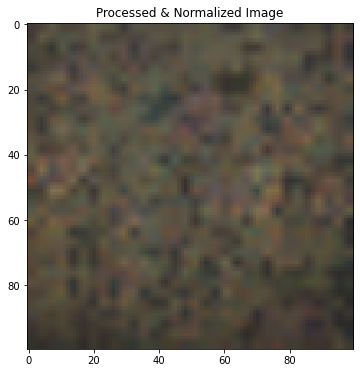

In [104]:
#image processing
X = X.astype('float32') #normalize image pixel with float values
X = X/255
indices = np.arange(X.shape[0]) #shuffling the images
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)

if len(Y) > 0:
    Y = to_categorical(Y)
    
processed_image = X[3]
processed_image = cv2.resize(processed_image, (100,100))
plt.imshow(processed_image)
plt.title("Processed & Normalized Image")
plt.show()


In [105]:
#train and test dataset split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print()
print("Training Size : "+str(X_train.shape[0]))
print("Testing Size  : "+str(X_test.shape[0]))
print()


Training Size : 320
Testing Size  : 80



In [106]:
labels = ["label1", "label2", "label3"]  # Replace with your actual labels

if os.path.exists('model.json'):
    with open('model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        cnn_model = model_from_json(loaded_model_json)
    json_file.close()
    cnn_model.load_weights("model_weights.h5")
else:
    cnn_model = Sequential()
    cnn_model.add(Convolution2D(32, 3, 3, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Convolution2D(32, 3, 3, activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(output_dim=256, activation='relu'))
    cnn_model.add(Dense(output_dim=y_train.shape[1], activation='softmax'))
    print(cnn_model.summary())
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    hist = cnn_model.fit(X_train, y_train, batch_size=16, epochs=100, shuffle=True, verbose=2, validation_data=(X_test, y_test))
    cnn_model.save_weights('model_weights.h5')
    model_json = cnn_model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    f = open('history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()

predict = cnn_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test = np.argmax(y_test, axis=1)

a = accuracy_score(y_test, predict) * 100
p = precision_score(y_test, predict, average='macro') * 100
r = recall_score(y_test, predict, average='macro') * 100
f = f1_score(y_test, predict, average='macro') * 100

print("CNN Accuracy  :  " + str(a))
print("CNN Precision : " + str(p))
print("CNN Recall    : " + str(r))
print("CNN FScore    : " + str(f))

conf_matrix = confusion_matrix(y_test, predict)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, cmap="viridis", fmt="g")
ax.set_ylim([0, len(labels)])
plt.title("CNN Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

3/3 [==============================] - 0s 8ms/step


ValueError: Classification metrics can't handle a mix of multiclass-multioutput and multiclass targets

/tmp/ipykernel_14052/1958547262.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(accuracy, 'ro-', color = 'green')
/tmp/ipykernel_14052/1958547262.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(val_acc, 'ro-', color = 'blue')


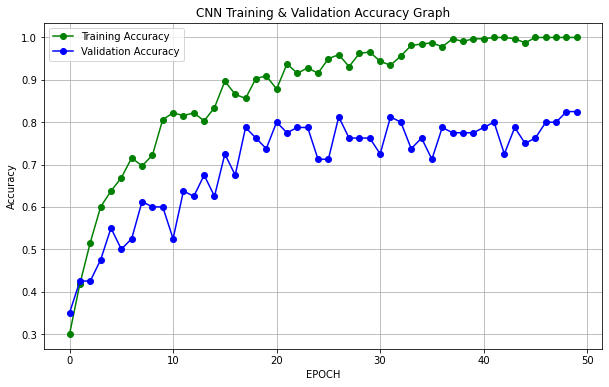

In [107]:
f = open('history.pckl', 'rb')
data = pickle.load(f)
f.close()
accuracy = data['accuracy']
val_acc = data['val_accuracy']
loss = data['loss']
val_loss = data['val_loss']

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.plot(accuracy, 'ro-', color = 'green')
plt.plot(val_acc, 'ro-', color = 'blue')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.title('CNN Training & Validation Accuracy Graph')
plt.show()

/tmp/ipykernel_14052/3458243135.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(loss, 'ro-', color = 'green')
/tmp/ipykernel_14052/3458243135.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(val_loss, 'ro-', color = 'blue')


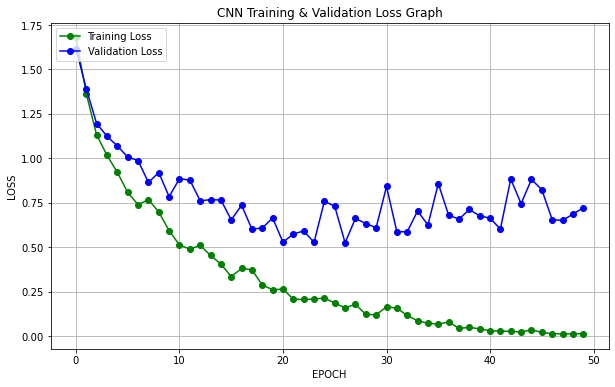

In [108]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.plot(loss, 'ro-', color = 'green')
plt.plot(val_loss, 'ro-', color = 'blue')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.title('CNN Training & Validation Loss Graph')
plt.show()

In [109]:
def register():
    global register_screen
    register_screen = Toplevel(main_screen)
    register_screen.title("Register Page")
    register_screen.geometry("600x600")
 
    global username
    global password
    global username_entry
    global password_entry
    
    name=StringVar()
    email=StringVar()
    
    username = StringVar()
    password = StringVar()
 
    Label(register_screen, text="Enter the details", bg="white").pack()
    Label(register_screen, text="").pack()
    
    name_lable = Label(register_screen, text="Name * ")
    name_lable.pack()
    name_entry = Entry(register_screen, textvariable=name)
    name_entry.pack()
    
    username_lable = Label(register_screen, text="Username * ")
    username_lable.pack()
    username_entry = Entry(register_screen, textvariable=username)
    username_entry.pack()
    
    password_lable = Label(register_screen, text="Password * ")
    password_lable.pack()
    password_entry = Entry(register_screen, textvariable=password, show='*')
    password_entry.pack()
    
    Label(register_screen, text="").pack()
    Button(register_screen, text="Register", width=10, height=1, bg="green", command = register_user).pack()
 

In [110]:
def login():
    global login_screen
    login_screen = Toplevel(main_screen)
    login_screen.title("Login")
    login_screen.geometry("400x350")
    Label(login_screen, text="Enter the details").pack()
    Label(login_screen, text="").pack()
 
    global username_verify
    global password_verify
 
    username_verify = StringVar()
    password_verify = StringVar()
 
    global username_login_entry
    global password_login_entry
 
    Label(login_screen, text="Username * ").pack()
    username_login_entry = Entry(login_screen, textvariable=username_verify)
    username_login_entry.pack()
    Label(login_screen, text="").pack()
    Label(login_screen, text="Password * ").pack()
    password_login_entry = Entry(login_screen, textvariable=password_verify, show= '*')
    password_login_entry.pack()
    Label(login_screen, text="").pack()
    Button(login_screen, text="Login", width=10, height=1, command = login_verify).pack()


In [111]:
def register_user():
 
    username_info = username.get()
    password_info = password.get()
 
    file = open(username_info, "w")
    file.write(username_info + "\n")
    file.write(password_info)
    file.close()
 
    username_entry.delete(0, END)
    password_entry.delete(0, END)
 
    Label(register_screen, text="Registration Success", fg="green", font=("calibri", 11)).pack()


In [112]:
def login_verify():
    username1 = username_verify.get()
    password1 = password_verify.get()
    username_login_entry.delete(0, END)
    password_login_entry.delete(0, END) 
    list_of_files = os.listdir()
    if username1 in list_of_files:
        file1 = open(username1, "r")
        verify = file1.read().splitlines()
        if password1 in verify:
            login_sucess() # login.destroy() 
        else:
            password_not_recognised() 
    else:
        user_not_found()

In [113]:
def exitApp():
    Close()

In [114]:
def uploadImage():
    from tkinter import filedialog
    global filename, cloth_screen, textfield
    textfield.delete('1.0', END)
    filename = filedialog.askopenfilename(parent=cloth_screen, initialdir="testImages")
    textfield.insert(END,filename+" loaded")
    

In [115]:
import extcolors
import webcolors
from IPython.display import display
import pandas as pd
from gtts import gTTS   
from playsound import playsound
from threading import Thread 
plt.rcParams["figure.figsize"]= [18,6]

In [116]:
def play(label, voice):
    class PlayThread(Thread):
        def __init__(self,label, voice):
            Thread.__init__(self) 
            self.label = label
            self.voice = voice

        def run(self):
            if os.path.exists("play/"+label+".mp3") == False:
                t1 = gTTS(text=voice, lang='en', slow=False)
                t1.save("play/"+label+".mp3")
            playsound("play/"+label+".mp3")            

    newthread = PlayThread(label, voice) 
    newthread.start()

In [117]:
def patternRecognition():
    global cnn_model, filename, cloth_screen
    image = cv2.imread(filename)
    img = cv2.resize(image, (32, 32))
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3)
    img = np.asarray(im2arr)
    img = img.astype('float32')
    img = img/255
    preds = cnn_model.predict(img)
    predict = np.argmax(preds)
    score = np.amax(preds)
    img = cv2.imread(filename)
    img = cv2.resize(img, (600,400))
    play(labels[predict], 'Pattern Recognized as : '+labels[predict])
    cv2.putText(img, 'Pattern Recognized as : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    cv2.imshow('Pattern Recognized as : '+labels[predict], img)
    cv2.waitKey(0)
    

In [118]:
plt.rcParams["figure.figsize"]= [18,6]

In [119]:
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = closest_name
    return actual_name

In [120]:
def clothh():
    global cloth_screen, main_screen, textfield
    login_screen.destroy()
    #main_screen.destroy()
    cloth_screen = Toplevel(main_screen)
    cloth_screen.title("Cloth Screen")
    cloth_screen.geometry("600x600")
    
    l1 = Label(cloth_screen,text="Pattern & Color Recognition Screen")
    l1.place(x=50,y=20)
    b1 = Button(cloth_screen, text="Upload Image", width=30, height=2, command = uploadImage)
    b1.place(x=50,y=70)
    
    b2 = Button(cloth_screen, text="Pattern Recognition", width=30, height=2, command = patternRecognition)
    b2.place(x=50,y=120)
    b3 = Button(cloth_screen, text="Color Recognition", width=30, height=2, command = colorRecognition)
    b3.place(x=50,y=170)
    b4 = Button(cloth_screen, text="Exit", width=30, height=2, command = exitApp)
    b4.place(x=50,y=220)
    
    font1 = ('times', 12, 'bold')
    textfield=Text(cloth_screen,height=15,width=80)
    textfield.place(x=50,y=270)
    scroll=Scrollbar(textfield)
    textfield.configure(yscrollcommand=scroll.set)
    textfield.config(font=font1)
    

In [121]:
def colorRecognition():
    global filename, textfield
    textfield.delete('1.0', END)
    colors_x = extcolors.extract_from_path(filename, tolerance = 12, limit = 12)
    colors_pre_list = str(colors_x).replace('([(','').split(', (')[0:-1]
    color = [i.split('), ')[0] + ')' for i in colors_pre_list]
    percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    values = []
    for i in range(len(percent)):
        values.append(int(percent[i].strip()))
    total = sum(values)
    bars = []
    height = []
    data = []
    for i in range(len(values)):
        c = color[i]
        p = values[i]
        c = c[1:len(c)-1]
        c = c.strip().split(",")
        r = int(c[0].strip())
        g = int(c[1].strip())
        b = int(c[2].strip())
        closest_name = get_colour_name((b, g, r))
        data.append([closest_name, str((p/total) * 100)+"%"])
        height.append((p/total) * 100)
        bars.append(closest_name)
        textfield.insert(END,closest_name+" "+str((p/total) * 100)+"%\n")
    df = pd.DataFrame(data, columns=['Colour Name', 'Percentage %']) 
    display(df)
    y_pos = np.arange(len(bars))
    plt.bar(y_pos, height)
    plt.xticks(y_pos, bars)
    plt.title("Colour Graph")
    plt.show()        

In [122]:
def login_sucess():
    clothh()
    

In [123]:
def password_not_recognised():
    global password_not_recog_screen
    password_not_recog_screen = Toplevel(login_screen)
    password_not_recog_screen.title("Success")
    password_not_recog_screen.geometry("150x100")
    Label(password_not_recog_screen, text="Invalid Password ").pack()
    Button(password_not_recog_screen, text="OK", command=delete_password_not_recognised).pack()

In [124]:
def user_not_found():
    global user_not_found_screen
    user_not_found_screen = Toplevel(login_screen)
    user_not_found_screen.title("Success")
    user_not_found_screen.geometry("150x100")
    Label(user_not_found_screen, text="User Not Found").pack()
    Button(user_not_found_screen, text="OK", command=delete_user_not_found_screen).pack() 
    
def delete_login_success():
    login_success_screen.destroy() 
    
def delete_password_not_recognised():
    password_not_recog_screen.destroy() 
    
def delete_user_not_found_screen():
    user_not_found_screen.destroy()

def Close():
    main_screen.destroy()


1/1 [==============================] - 0s 20ms/step


Exception in Tkinter callback
Exception in thread Thread-14:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/tmp/ipykernel_14052/3420056702.py", line 17, in patternRecognition
    cv2.imshow('Pattern Recognized as : '+labels[predict], img)
cv2.error: OpenCV(4.7.0) /io/opencv/modules/highgui/src/window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'

    self.run()
  File "/tmp/ipykernel_14052/3608340684.py", line 11, in run
  File "/home/ashraf/.local/lib/python3.10/site-packages/gtts/tts.py", line 324, in save
    with open(str(savefile), "wb") as f:
FileNotFoundErro

1/1 [==============================] - 0s 21ms/step


Exception in Tkinter callback
Exception in thread Thread-15:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/tmp/ipykernel_14052/3420056702.py", line 17, in patternRecognition
    cv2.imshow('Pattern Recognized as : '+labels[predict], img)
cv2.error: OpenCV(4.7.0) /io/opencv/modules/highgui/src/window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'

    self.run()
  File "/tmp/ipykernel_14052/3608340684.py", line 11, in run
  File "/home/ashraf/.local/lib/python3.10/site-packages/gtts/tts.py", line 324, in save
    with open(str(savefile), "wb") as f:
FileNotFoundErro

1/1 [==============================] - 0s 20ms/step


Exception in Tkinter callback
Exception in thread Thread-16:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/tmp/ipykernel_14052/3420056702.py", line 17, in patternRecognition
    cv2.imshow('Pattern Recognized as : '+labels[predict], img)
cv2.error: OpenCV(4.7.0) /io/opencv/modules/highgui/src/window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'

    self.run()
  File "/tmp/ipykernel_14052/3608340684.py", line 11, in run
  File "/home/ashraf/.local/lib/python3.10/site-packages/gtts/tts.py", line 324, in save
    with open(str(savefile), "wb") as f:
FileNotFoundErro

,Colour Name,Percentage %
0,dimgray,40.33547248684473%
1,gray,16.03262296631621%
2,rosybrown,8.896480374754487%
3,darkslategray,8.835561764118937%
4,gray,6.7837599386612615%
5,tan,4.513228791395772%
6,dimgray,3.9557709880368455%
7,navajowhite,3.8391853711308808%
8,tan,3.288554653446628%
9,darkseagreen,1.9499207007740864%


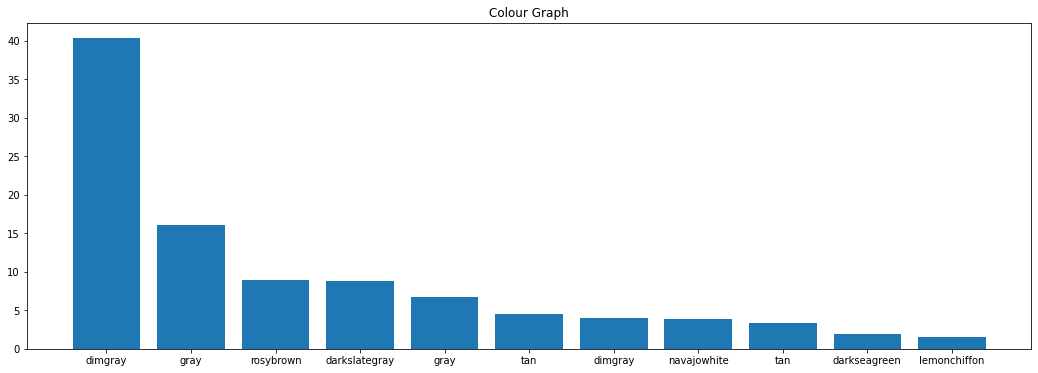

In [125]:
def main_account_screen():
    global main_screen
    main_screen = Tk()
    main_screen.geometry("600x450")
    main_screen.title("Cloth Color Regonization")
    
    Label(text="Main page", bg="white", width="300", height="2", font=("Calibri", 13)).pack()
    
    Label(text="").pack()
    Button(text="Register", height="2", width="30", command=register).pack()
    
    Label(text="").pack()
    Button(text="Login", height="2", width="30", command = login).pack()


    Label(text="").pack()
    Button(text="Exit", height="2", width="30", command = Close).pack()
    
    # Label(text="").pack()
    # Button(text="Color Recognition", height="2", width="30", command=cloth).pack()     
    main_screen.mainloop() 
main_account_screen()